# Feature engineering for forecasting

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook, we will create a table of predictive features and a target from a time series dataset.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Load data

We will use the electricity demand dataset found [here](https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec/VIC2015).

**Citation:**

Godahewa, Rakshitha, Bergmeir, Christoph, Webb, Geoff, Hyndman, Rob, & Montero-Manso, Pablo. (2021). Australian Electricity Demand Dataset (Version 1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4659727

**Description of data:**

A description of the data can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). The data contains electricity demand in Victoria, Australia, at 30 minute intervals over a period of 12 years, from 2002 to early 2015. There is also the temperature in Melbourne at 30 minute intervals and public holiday dates.

In [3]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("h")
    .agg({"demand": "sum"})
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [4]:
# check first and last date of record

df.index.min(), df.index.max()

(Timestamp('2002-01-01 00:00:00'), Timestamp('2015-02-28 23:00:00'))

In [5]:
# number of measurements

df.shape

(115368, 1)

## Check seasonality

To understand which features we should create, it is useful to do time series analysis to discover seasonalities and trends, among other time series characteristics.

Here, we'll do the minimum as example. We have more details in our other course on [Feature Engineering for Time Series Forecasting](https://www.trainindata.com/p/feature-engineering-for-forecasting)

### Daily seasonality

Let's begin by addressing the energy consumption throughout a day.

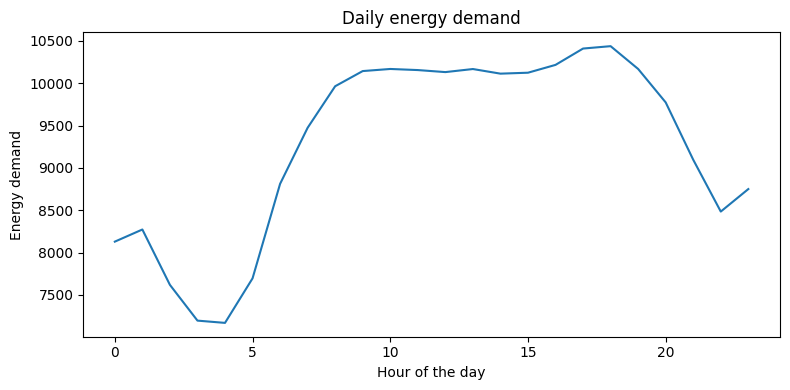

In [6]:
hour = df.index.hour

# take the mean energy consumption per hour
df.groupby(hour).mean(numeric_only=True)["demand"].plot(figsize=(8,4))

# plot
plt.title("Daily energy demand")
plt.ylabel("Energy demand")
plt.xlabel("Hour of the day")
plt.tight_layout()

Most energy is consumed within wake hours, that is, when people are not sleeping. No surprise here.

### Weekly

Now, let's evaluate if the energy consumption varies during the week.

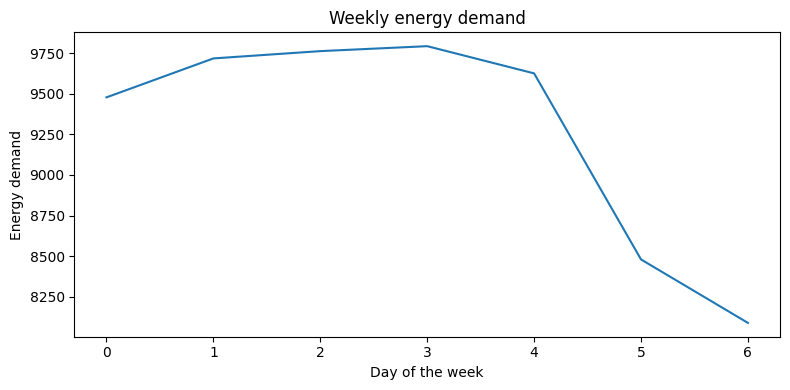

In [7]:
day = df.index.dayofweek

# we take the mean energy consumption per day
df.groupby(day).mean(numeric_only=True)["demand"].plot(figsize=(8,4))

# plot
plt.title("Weekly energy demand")
plt.ylabel("Energy demand")
plt.xlabel("Day of the week")
plt.tight_layout()

Most energy is consumed during working days.

### Yearly

Now, let's see if there is yearly seasonality.

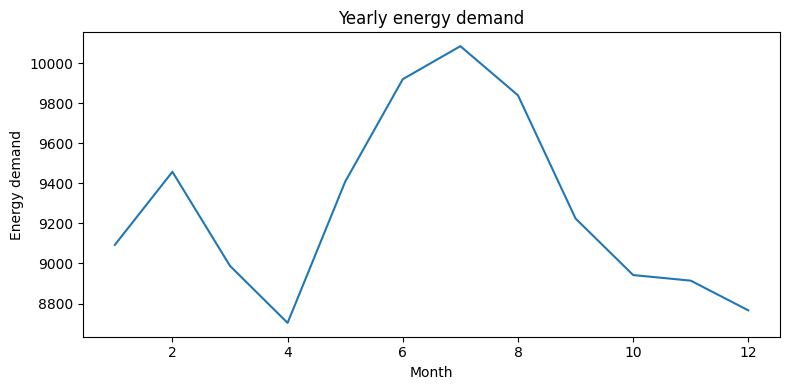

In [8]:
month = df.index.month

# we take the mean energy consumption per month
df.groupby(month).mean(numeric_only=True)["demand"].plot(figsize=(8,4))

# plot
plt.title("Yearly energy demand")
plt.ylabel("Energy demand")
plt.xlabel("Month")
plt.tight_layout()

Most energy is consumed during winter. This is Australia, and June-August is winter. It makes sense, the days are shorter, we need more light and also potentially heating is electric.

Now, we'll start tabularizing our time series.

## Lag features

We shift past values of the time series forward.

In [9]:
# First, we create a feature that is the prior value to the value
# we want to predict. Lag 1 in other words.

lag = 1  # As the time series is uniformly spaced by hours we can
         # specify the lag in terms of the number of periods. In
         # this case the period is in unit of hours.

df[f"y_lag_{lag}"] = df["demand"].shift(periods=lag)

df.head()

,demand,y_lag_1
date_time,,
2002-01-01 00:00:00,6919.366092,NaN
2002-01-01 01:00:00,7165.974188,6919.366092
2002-01-01 02:00:00,6406.542994,7165.974188
2002-01-01 03:00:00,5815.537828,6406.542994
2002-01-01 04:00:00,5497.732922,5815.537828


In [10]:
# Now we use as feature the same hour, but in the previous day

# We can also specify the freq of the time index and append the
# number of periods to shift by at the start of the string, 
# omitting the period argument entirely.

freq = "24h"
df[f"y_lag_{freq}"] = df["demand"].shift(freq=freq)

df.head(30)

,demand,y_lag_1,y_lag_24h
date_time,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,NaN
2002-01-01 04:00:00,5497.732922,5815.537828,NaN
2002-01-01 05:00:00,5385.851060,5497.732922,NaN
2002-01-01 06:00:00,5574.731890,5385.851060,NaN
2002-01-01 07:00:00,5457.770634,5574.731890,NaN
2002-01-01 08:00:00,5698.152000,5457.770634,NaN


In [11]:
# Finally, we can use the same hour, but in the previous week

freq = "7d"
df[f"y_lag_{freq}"] = df["demand"].shift(freq=freq)

df.head()

,demand,y_lag_1,y_lag_24h,y_lag_7d
date_time,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,NaN
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,NaN


## Window features

We aggregate values within windows in the past.

In [12]:
# We'll use a 3H window size.

result = (
    df["demand"]
    .rolling(window=3) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1h") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("y_window_3_")

result

,y_window_3_mean,y_window_3_std
date_time,,
2002-01-01 01:00:00,NaN,NaN
2002-01-01 02:00:00,NaN,NaN
2002-01-01 03:00:00,6830.627758,387.414253
2002-01-01 04:00:00,6462.685003,676.966421
2002-01-01 05:00:00,5906.604581,461.198224
...,...,...
2015-02-28 20:00:00,9945.090785,332.275255
2015-02-28 21:00:00,9486.639086,556.573732
2015-02-28 22:00:00,8933.422635,639.736706


In [13]:
# add features to main dataframe

df = df.merge(result, how="left", left_index=True, right_index=True)

df.head()

,demand,y_lag_1,y_lag_24h,y_lag_7d,y_window_3_mean,y_window_3_std
date_time,,,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,NaN,6830.627758,387.414253
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,NaN,6462.685003,676.966421


In [14]:
# double check values

(6919.366092 + 7165.974188 + 6406.542994) / 3

6830.627758

In [15]:
# We'll use a window size of 24 hours to smooth 
# over daily seasonality.

result = (
    df["demand"]
    .rolling(window=24) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1h") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("y_window_24_")

# add features to main dataframe
df = df.merge(result, how="left", left_index=True, right_index=True)

df.head(30)

,demand,y_lag_1,y_lag_24h,y_lag_7d,y_window_3_mean,y_window_3_std,y_window_24_mean,y_window_24_std
date_time,,,,,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,NaN,6830.627758,387.414253,NaN,NaN
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,NaN,6462.685003,676.966421,NaN,NaN
2002-01-01 05:00:00,5385.851060,5497.732922,NaN,NaN,5906.604581,461.198224,NaN,NaN
2002-01-01 06:00:00,5574.731890,5385.851060,NaN,NaN,5566.373937,222.915615,NaN,NaN
2002-01-01 07:00:00,5457.770634,5574.731890,NaN,NaN,5486.105291,94.975751,NaN,NaN
2002-01-01 08:00:00,5698.152000,5457.770634,NaN,NaN,5472.784528,95.331289,NaN,NaN


## Datetime features

The smallest time feature that makes sense is hour, because our records are hourly. We also saw that we have daily and weekly seasonality, so it makes sense to have those as features as well.

In [16]:
df["month"] = df.index.month
df["day"] = df.index.dayofweek
df["hour"] = df.index.hour

df.head()

,demand,y_lag_1,y_lag_24h,y_lag_7d,y_window_3_mean,y_window_3_std,y_window_24_mean,y_window_24_std,month,day,hour
date_time,,,,,,,,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,NaN,6830.627758,387.414253,NaN,NaN,1,1,3
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,NaN,6462.685003,676.966421,NaN,NaN,1,1,4


## Finalize tabularization

Now we just separate our data into the table of features and the target variable.

In [17]:
df.dropna(inplace=True)

y = df["demand"]
X = df.drop("demand", axis=1)

# Predictors

X.head()

,y_lag_1,y_lag_24h,y_lag_7d,y_window_3_mean,y_window_3_std,y_window_24_mean,y_window_24_std,month,day,hour
date_time,,,,,,,,,,
2002-01-08 00:00:00,7406.047910,6808.008916,6919.366092,7003.111898,369.947168,7637.818532,865.185351,1,1,0
2002-01-08 01:00:00,7077.081904,7209.285712,7165.974188,7053.973603,364.178734,7649.029907,855.655756,1,1,1
2002-01-08 02:00:00,7445.354310,6535.818342,6406.542994,7309.494708,202.232618,7658.866098,851.728742,1,1,2
2002-01-08 03:00:00,6800.577478,6112.382636,5815.537828,7107.671231,323.474993,7669.897729,838.157008,1,1,3
2002-01-08 04:00:00,6340.914086,6165.882096,5497.732922,6862.281958,554.799634,7679.419873,820.811716,1,1,4


In [18]:
# target

y.head()

date_time
2002-01-08 00:00:00    7077.081904
2002-01-08 01:00:00    7445.354310
2002-01-08 02:00:00    6800.577478
2002-01-08 03:00:00    6340.914086
2002-01-08 04:00:00    6277.978250
Freq: h, Name: demand, dtype: float64

That's it! We can now forecast the energy demand in the next hour as a regression.

In this notebook, we only extracted features from the time series. We can add more features from external data sources. We will address that in coming notebooks.